In [2]:
# ============================================================
# CELL 1: Install required libraries
# ============================================================
# SHAP and LIME are used for explainability
# XGBoost is optional but gives strong performance

!pip -q install shap lime xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# ============================================================
# CELL 2: Import libraries
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay
)

from xgboost import XGBClassifier

import shap
from lime.lime_tabular import LimeTabularExplainer

# Improve plot appearance
plt.rcParams["figure.figsize"] = (7, 5)

In [4]:
# ============================================================
# CELL 3: Load the Wisconsin Breast Cancer dataset
# ============================================================

data = load_breast_cancer()

# Convert dataset to DataFrame for easier handling
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# IMPORTANT NOTE:
# target = 0 -> malignant
# target = 1 -> benign

print("Dataset shape:", X.shape)
print("\nTarget distribution:")
print(y.value_counts())

Dataset shape: (569, 30)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64


In [5]:
# ============================================================
# CELL 4: Split data into training and testing sets
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance
)

print("Training set shape:", X_train.shape)
print("Testing set shape :", X_test.shape)

Training set shape: (455, 30)
Testing set shape : (114, 30)


In [6]:
# ============================================================
# CELL 5: Feature scaling
# ============================================================
# Scaling is important for Logistic Regression

scaler = StandardScaler()

# Fit scaler on training data ONLY
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (helps SHAP & readability)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [7]:
# ============================================================
# CELL 6: Train ML models
# ============================================================

# 1) Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train_scaled_df, y_train)

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# 3) XGBoost (advanced model)
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)

print("All models trained successfully!")

All models trained successfully!


In [8]:
# ============================================================
# CELL 7: Model evaluation function
# ============================================================

def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates a classification model using common metrics
    and visualizes Confusion Matrix + ROC Curve.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {model_name} =====")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=data.target_names)
    disp.plot(values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()



===== Logistic Regression =====
Accuracy : 0.9824561403508771
Precision: 0.9861111111111112
Recall   : 0.9861111111111112
F1-score : 0.9861111111111112
ROC-AUC  : 0.9953703703703703


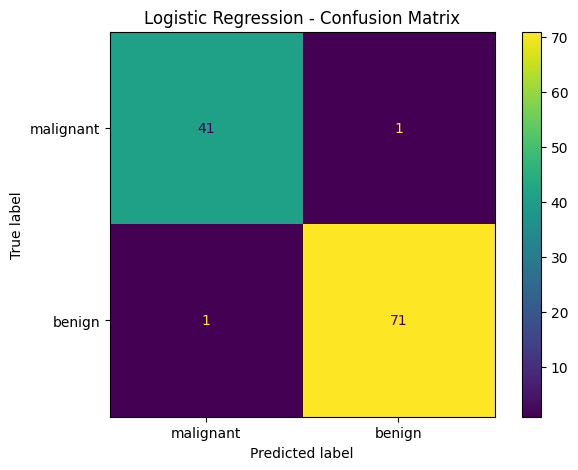

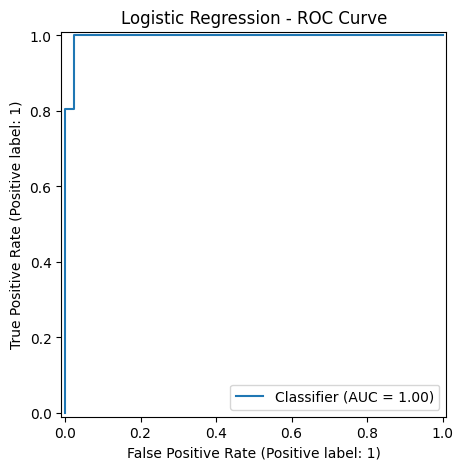


===== Random Forest =====
Accuracy : 0.9473684210526315
Precision: 0.9583333333333334
Recall   : 0.9583333333333334
F1-score : 0.9583333333333334
ROC-AUC  : 0.9937169312169313


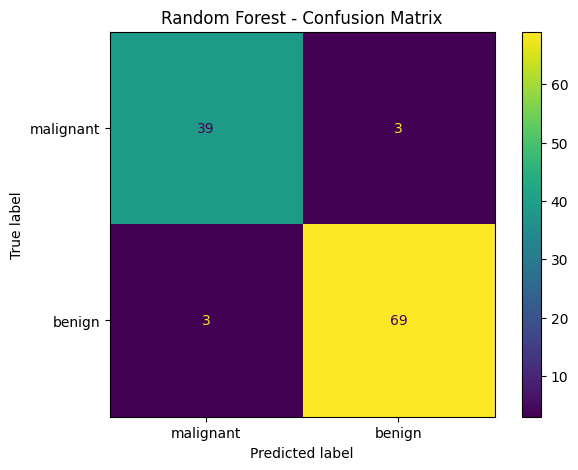

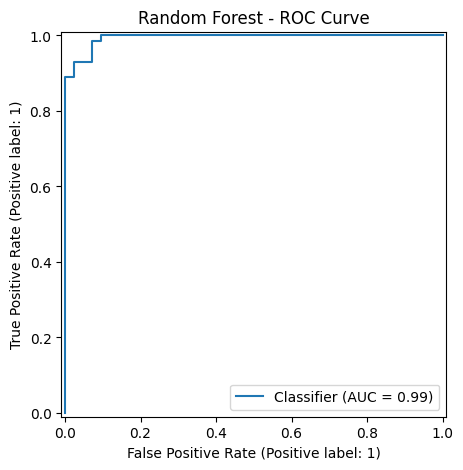


===== XGBoost =====
Accuracy : 0.956140350877193
Precision: 0.9466666666666667
Recall   : 0.9861111111111112
F1-score : 0.9659863945578231
ROC-AUC  : 0.9950396825396826


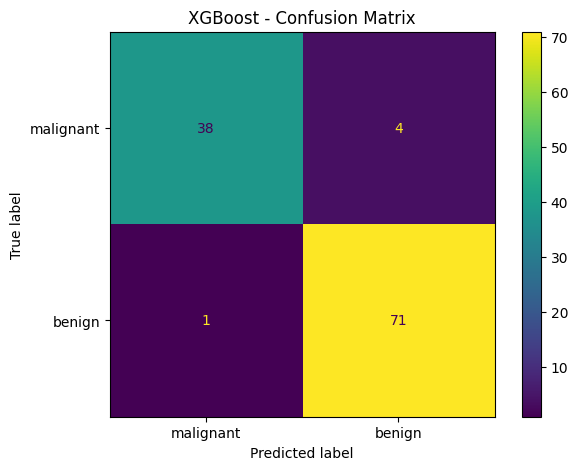

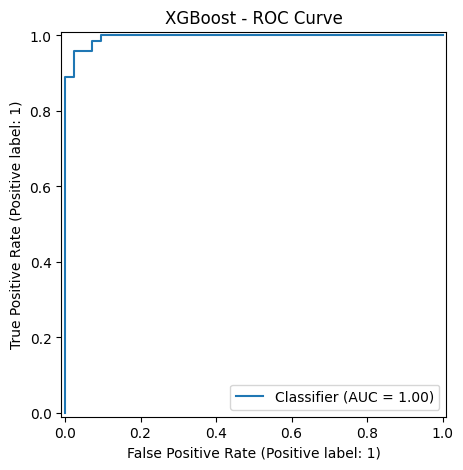

In [9]:
# ============================================================
# CELL 8: Evaluate models
# ============================================================

evaluate_model(log_reg, X_test_scaled_df, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")


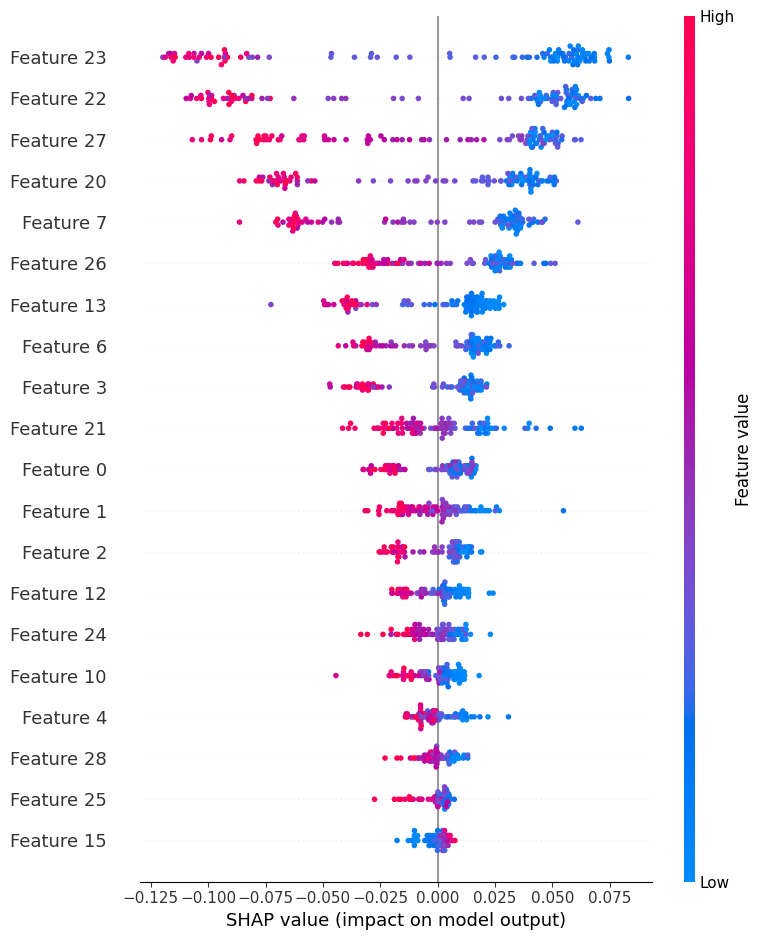

In [10]:
# ============================================================
# CELL 9: SHAP Explainability for Random Forest
# ============================================================

# Background data for SHAP (smaller sample = faster)
background_rf = X_train.sample(200, random_state=42)

# TreeExplainer for tree-based models
explainer_rf = shap.TreeExplainer(rf, background_rf)

# Explain a subset of test data
X_test_sample = X_test.sample(100, random_state=42) # Changed sample size from 200 to 100
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# Summary plot for class "benign"
shap.summary_plot(shap_values_rf[:, :, 1], X_test_sample.values)

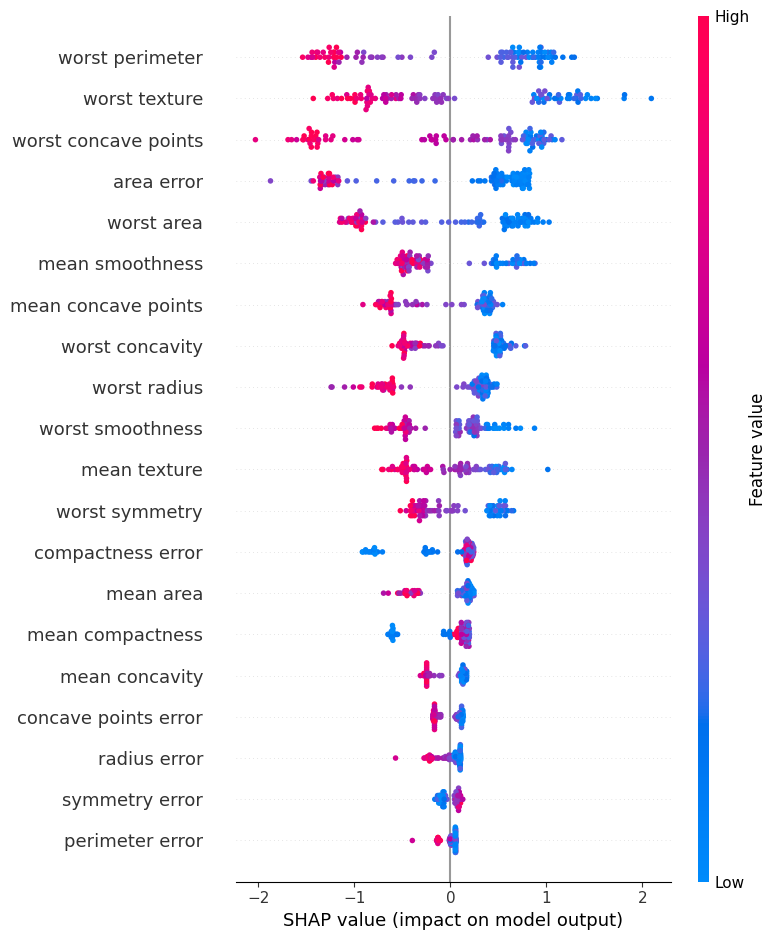

In [12]:
# ============================================================
# CELL 10: SHAP Explainability for XGBoost
# ============================================================

background_xgb = X_train.sample(200, random_state=42)
explainer_xgb = shap.TreeExplainer(xgb, background_xgb)

X_test_sample = X_test.sample(100, random_state=42) # Changed sample size from 200 to 100
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

shap.summary_plot(shap_values_xgb, X_test_sample)

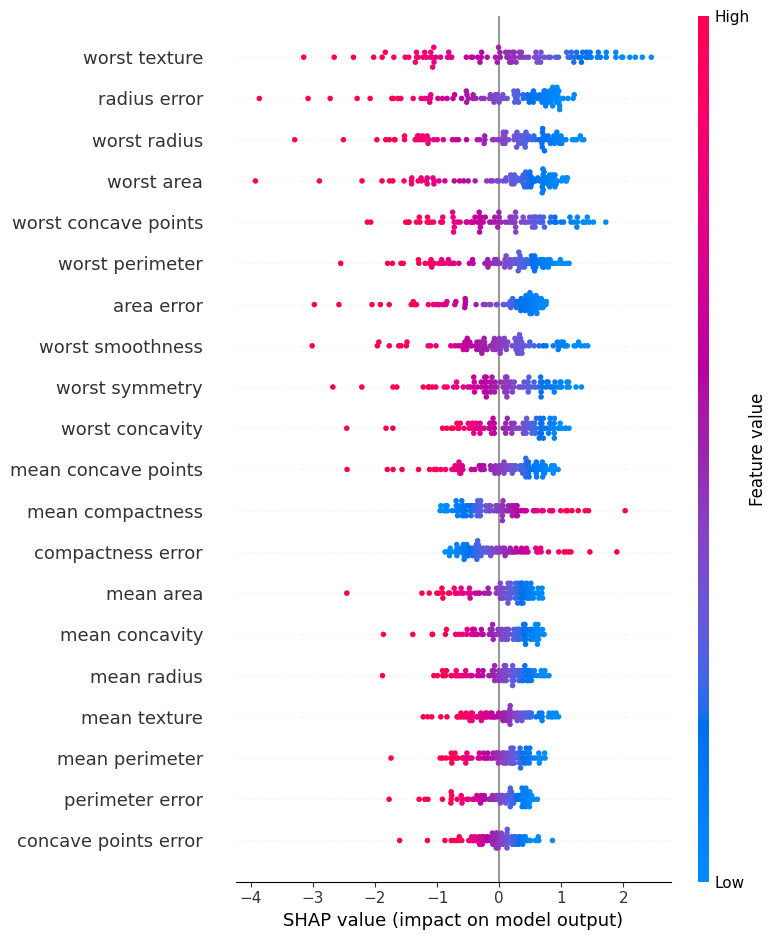

In [14]:
# ============================================================
# CELL 11: SHAP Explainability for Logistic Regression
# ============================================================

background_lr = X_train_scaled_df.sample(200, random_state=42)

explainer_lr = shap.LinearExplainer(
    log_reg,
    background_lr,
    feature_perturbation="interventional"
)

X_test_sample = X_test_scaled_df.sample(100, random_state=42)
shap_values_lr = explainer_lr.shap_values(X_test_sample)

shap.summary_plot(shap_values_lr, X_test_sample)


In [15]:
# ============================================================
# CELL 12: LIME Local Explanation
# ============================================================

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=data.target_names.tolist(),
    mode="classification"
)

# Pick one test instance
idx = X_test.index[0]
instance = X_test.loc[idx].values

# Generate explanation
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=rf.predict_proba,
    num_features=10
)

print("True label:", data.target_names[y_test.loc[idx]])
print("Predicted :", data.target_names[rf.predict(X_test.loc[[idx]])[0]])

lime_exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


True label: malignant
Predicted : malignant


In [16]:
# ============================================================
# CELL 13: Single-sample prediction + SHAP force plot
# ============================================================

shap.initjs()

single_sample = X_test.iloc[[0]]

prediction = xgb.predict(single_sample)[0]
probability = xgb.predict_proba(single_sample)[0, 1]

print("Predicted class:", data.target_names[prediction])
print("Probability (benign):", round(probability, 4))

# SHAP force plot
single_shap = explainer_xgb.shap_values(single_sample)
shap.force_plot(explainer_xgb.expected_value, single_shap, single_sample)


Predicted class: malignant
Probability (benign): 0.0005
